
**Quick Draw** 게임을 해보니 제한 시간 안에 그림을 그리면 AI가 "이건가요?" "저건가요?" 말하다가 "아 알겠어요 이건 만리장성입니다." 이런 게임이다. 사실 엄청나게 놀랬다. 완성된 그림을 주는 게 아니라 한 획, 한 획 그리는 와중에 정답을 말하는 AI의 성능이 대단하다고 생각했다. class가 340개라는 한정이 있지만 모든 사람이 동그라미조차도 같게 그리지 않으므로 만리장성을 맞춘 건 대단하다고 생각한다.

데이터셋을 받아서 구조 분석을 하는 데에는 Getting Started{[image-Based CNN](https://www.kaggle.com/jpmiller/image-based-cnn),[Quick Draw! - Simple EDA](https://www.kaggle.com/dimitreoliveira/quick-draw-simple-eda)} 커널을 참고했다. 나의 예상과는 다르게 인풋 데이터가 이미지가 아닌 선들의 좌표 배열이었다. 이 좌표를 이용해서 다시 이미지로 변환한 다음 input으로 사용할 예정이다. 이미지를 분류하는 데는 CNN이 성능이 가장 좋으니까 CNN을 포커스로 잡고 진행하였다.

데이터가 선 1, 선 2, 선 3 이런 식으로 시간의 속성이 들어가서 LSTM을 적용해도 괜찮을 것 같지만 자신 있는 CNN으로 과제를 진행하고 시간이 남는다면 바꿔보는 것도 괜찮을 것 같다.

***

# 1차 사용 방법 

**CNN**<br>
이미지의 데이터가 많은 상황에서 CNN은 최고의 성능을 낸다. 

**keras**<br>
원래 tensorflow를 사용했었지만, 카글에서 keras를 처음 사용해봤다.<br>
input, kernel, output을 블록으로 설명한 부분이 인상 깊었고 tensorflow 기반으로 만들어져서 그런지 습득하고 사용하는데 많은 부담감은 없었다.<br>
코드가 훨씬 깔끔하고 사용하기 쉽지만 keras가 tensorflow를 커버할 수 없다고 한다. 이는 좀 더 사용해봐야 알 것 같다.

***

# 2차 사용 방법

**배치 사이즈와 에폭수를 늘려보았다.** 

- batch_size = 32, epochs = 22 <br> 
 Private Score 0.60357 <br>
 Public Score 0.60229

- batch_size = 128, epochs = 50 <br>
Private Score 0.62959 <br>
Public Score 0.63262

- batch_size = 128, epochs = 100 <br>
Private Score 0.62893 <br>
Public Score 0.62818

하이파라미터에 의존하는 것보단 다른 방법을 생각해봐야겠다.

***


# 3차 사용 방법 

2차 사용 방법은 '전체 데이터셋을 한 번에 읽어오는 방법'이다. 최종적으로 (680000, 1025) 배열을 만들었다. <br>
keras 에서 model.fit_generator() 함수를 보고 스텝 바이 스텝으로 data generator를 만드는 것을 적용해보았다. 

==> 실패했다. <br>
왜 실패한 건지 도무지 모르겠다. 에폭이 증가하지 않는다. <br>
[Fork of Quick_Draw_FAIL](https://www.kaggle.com/rookiebox/fork-of-quick-draw-cnn-fail)커널에 기록해놨다.<br>
모델의 input의 shape와 데이터의 shape를 맞춰주면 될 것 같았지만, 실행이 되지 않았다. 에러 메세지도 출력되지 않고 어느 순간 CPU의 점유율이 0%로 떨어졌다.

***

# 4차 사용 방법

클래스 마다(.csv) 2500개의 값 중 (recognized == True) 을 만족하는 2000개의 값만 사용한다. <br>
이를 무작정 10000 값으로 늘려봤다. 하지만 이 많은 데이터를 한 번에 로드하는 것은 메모리가 버티지 못해 문제가 생겼고(중간에 커널의 연결이 계속 off 되었다)<br>
'좌표를 이용해서 다시 이미지로 변환'하는 과정이 생각보다 너무 오래 걸려서 다른 방법을 생각해봐야 겠다.

기존 데이터셋의 [None, 32, 32, 1] 배열을 [None, 80, 2]로 바꿔보았다. <br>
다른 코드를 살펴보니 x, y 값이 차례로 있다고 한다. 연속된 좌표의 패턴을 학습해보자.
단, 이렇게 input 데이터의 shape를 바꾸면 기존에 사용했던 모델을 변경해야 한다.

==> 성공했다. <br>
한 클래스당 사용하는 값의 수를 2000에서 10000으로 5배 늘렸다. <br>
기존 [32,32] shape에서 [80,2] shape로 줄이니 연산속도가 더 빨랐고 더 많은 값을 사용할 수 있었다. <br>
기존에 사용했던 2D Convolution을 1D Convolution 모델로 변경하고 돌려보았다.

- epochs = 3 <br> 
 Private Score 0.71686<br>
 Public Score 0.71671
- epochs = 10 <br> 
 Private Score 0.76240 <br>
 Public Score 0.75738
- epochs = 30 <br> 
 Private Score <br>
 Public Score 
 30에서 강제 새로고침을 당했다...
- epochs = 25 <br> 
 Private Score 0.77515<br>
 Public Score 0.77511
***

아쉬운 점 <br>
keras의 EarlyStopping 함수를 사용해보고 싶었는데 callback으로 넣어주면 자꾸 에러가 생겨 진행이 안 돼서 뺐다. 그래서 어느 시점에 epoch을 멈춰야하는지 일일이 돌려봐야 했다. 

***

## training data 구조 분석
'Getting Started' kernel을 참고했다.<br>
- glob 폴데에 있는 모든 파일 접근해서 list 형태로 변환
- tqdm for문의 상태바 보여줌

In [1]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fnames = glob('../input/train_simplified/*.csv') #<class 'list'>
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:6]: # num of word : 5
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2) # top head 2 get 
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames) # <class 'pandas.core.frame.DataFrame'>
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[92, 91, 82, 69, 64, 56, 28, 15, 6, 0, 1, 18...",4745881255411712,True,2017-03-10 13:46:31.635970,sleeping bag
1,AU,"[[[4, 3, 11, 22, 38, 63, 251, 255, 251, 252, 2...",4573190200229888,True,2017-03-17 06:36:27.083520,sleeping bag
2,GB,"[[[28, 110, 126, 106, 59, 37, 32, 25], [168, 1...",5546137161302016,True,2017-03-29 12:39:34.815400,house plant
3,GB,"[[[60, 60, 62, 69, 98, 116, 169, 171, 157, 152...",6020882763874304,True,2017-03-03 12:09:53.163390,house plant
4,BR,"[[[48, 119, 208, 222, 228, 209, 175, 80, 25, 7...",4801185506656256,True,2017-01-26 00:40:23.964940,bathtub
5,GB,"[[[17, 230], [138, 136]], [[1, 8, 21, 33, 55, ...",5242011433041920,True,2017-03-21 19:08:39.365000,bathtub
6,US,"[[[4, 0, 2], [202, 98, 24]], [[1, 12, 10, 25, ...",5223042911305728,True,2017-03-18 02:52:34.909590,key
7,GB,"[[[36, 25, 9, 0, 0, 15, 30, 75, 90, 95, 97, 84...",5425151371902976,True,2017-03-04 09:29:43.337260,key
8,US,"[[[69, 32, 19, 7, 0, 18, 55, 86, 145, 196, 209...",4848879067463680,True,2017-03-06 15:00:27.328800,triangle
9,US,"[[[98, 48, 0], [0, 108, 235]], [[100, 133, 171...",5548323891052544,True,2017-01-27 12:47:55.869040,triangle


그림 데이터는 아래와 같이 숫자들의 배열로 저장한다. 
```
drawing.values = [[선1점1, 선1점2, 선1점3, ... 선1점n], [선2점1, 선2점2, 선2점3, ... 선2점n], ..., [선i점1, 선i점2, 선i점3, ... 선i점n]]
```

In [3]:
draw_df.drawing.values[0]

'[[[92, 91, 82, 69, 64, 56, 28, 15, 6, 0, 1, 18, 27, 54, 69, 83, 92, 92], [143, 78, 60, 15, 6, 0, 1, 14, 29, 85, 224, 250, 253, 255, 246, 227, 184, 105]], [[59, 39, 13, 10, 38], [73, 80, 80, 74, 81]]]'

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


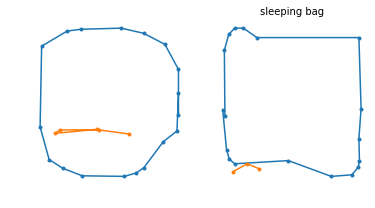

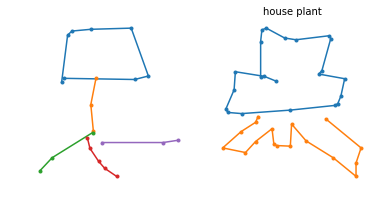

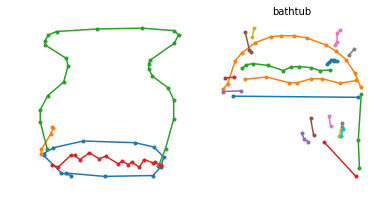

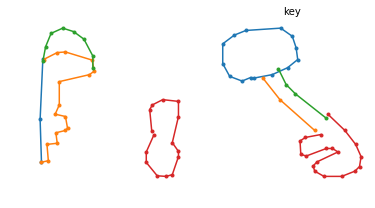

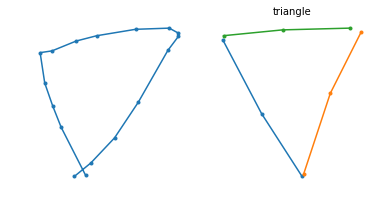

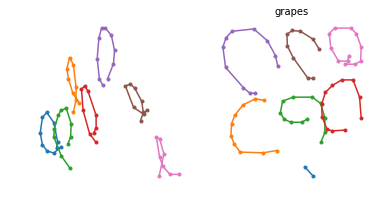

In [4]:
evens = range(0,11,2)
odds = range(1,12, 2)
# We have drawing images, 2 per label, consecutively
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]
labels = df2.word.tolist()

for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()  

In [5]:
%reset -f

## 모델 만들기

이제 CNN 모델을 만들어보자.<br>
csv의 데이터에서 x, y점의 좌표를 읽어와 모델의 input으로 주기 위한 전처리 작업이 필요하다.

- Dask 패키지는 Pandas 데이터프레임 형식으로 빅데이터를 처리하기 위한 파이썬 패키지이다.

### **코드의 주석은 1차 사용 방법의 주석입니다. **

In [6]:

import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, Flatten, MaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


> The data are also available in a zip file (automatically extracted inside the Kernels environment).
> 카글은 대단하다.

In [7]:
path = '../input/train_simplified/'
classfiles = os.listdir(path)

numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} # sleeping bag -> sleeping_bag
files = [os.path.join(path, file) for i, file in enumerate(classfiles)]
word_mapping = {file.split('/')[-1][:-4]:i for i, file in enumerate(files)}

num_classes = len(files)    #340
imheight, imwidth = 32, 32 # size of an image
ims_per_class = 2000  #max? # in the code above and above, there existed more than 100 thousand images per class(/label)
sequence_length = 80

## 1. TRAIN 데이터 만들기 

한 class 마다 (class 개수는 340) sleeping bag.csv 에서 15000 읽어온다. (단, 필요한 col인 'drawing', 'recognized'만 뽑아온다)<br>
이중 'recognized' 가 'True' 인 애들 탑 10000 개를 뽑는다.

**배열 X**<br>
sequence of x- 와 y-coordinates 의 패턴을 X 배열에 넣는다. [10000, 80, 2]<br>
X 배열의 차원을 줄여 [10000, 160] 배열을 만든다.

**배열 y**<br>
y 배열에는 class를 구별할 수 있는 index 값을 넣어 [10000, 1] 배열을 만든다.

X와 y 배열을 합쳐준다. [10000, 161]

**배열 train_grand**<br>
[10000, 161] 을 'train_grand'에 append 해준다.<br>
shape을 변경해준다. [340, 10000, 161] -> [3400000, 161]




In [8]:
train_grand= []

class_paths = glob('../input/train_simplified/*.csv')

df = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=15000) # [2500 rows x 2 columns]
    train = train[train.recognized == True].head(10000) # use data only recognized == True -> [2000 rows x 2 columns]
    
    X = []
    for values in train.drawing.values:
        image = json.loads(values)
        strokes = []
        for x_axis, y_axis in image:
            strokes.extend(list(zip(x_axis, y_axis)))
        strokes = np.array(strokes)
        pad = np.zeros((sequence_length, 2))
        if sequence_length>strokes.shape[0]:
            pad[:strokes.shape[0],:] = strokes
        else:
            pad = strokes[:sequence_length, :]
        X.append(pad)
    X = np.array(X)
    y = np.full((train.shape[0], 1), i)
    X = np.reshape(X, (10000, -1))
    X = np.concatenate((y, X), axis=1)
    train_grand.append(X)
   
    
#     trainarray = np.reshape(trainarray, (ims_per_class, -1)) # (2000, 1024)
#     labelarray = np.full((train.shape[0], 1), i) # (2000, 1) fill with 'i' 0~339
#     trainarray = np.concatenate((labelarray, trainarray), axis=1) # (2000, 1025)
#     train_grand.append(trainarray)

train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
print(train_grand.shape)
train_grand = train_grand.reshape((-1, sequence_length*2+1))
print(train_grand.shape)

del X
del train

100%|██████████| 340/340 [02:37<00:00,  2.02it/s]


(340, 10000, 161)
(3400000, 161)


## 2. TRAIN, VALIDATION data 나누기

전체 데이터 셋 3400000중 10%는 validation data로 90%는 train data로 사용한다.
  
y_train : (3060000, 340)

X_train : (3060000, 80, 2) 

y_val : (340000, 340) 

X_val : (340000, 80, 2)


> keras.utils.to_categorical() 은 
> 
> ex: y_tain=[0,2,1,2,0] 이라하면, 
> y_train= [[ 1.,  0.,  0.],
>          [ 0.,  0.,  1.],
>          [ 0.,  1.,  0.],
>          [ 0.,  0.,  1.],
>          [ 1.,  0.,  0.]] 로 변경된다.

In [9]:
valfrac = 0.1 
cutpt = int(valfrac * train_grand.shape[0])
print(cutpt)

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:]

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(-1, sequence_length,2)

y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(-1, sequence_length,2)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)


340000
(3060000, 340) 
 (3060000, 80, 2) 
 (340000, 340) 
 (340000, 80, 2)


## 3. keras 를 이용해 model 정의하기

x, y 의 sequece pattern을 파악하기 위해 conv1을 사용했다.


> Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1))
> - 입력 : (32, 32) 채널은 1개
> - 중간 : (3, 3)커널 필터개수 32개
> - 아웃 : (32, 32) 채널은 32개
> - 가중치 개수 : 3x3x32 = 288개
> - 참고로 케라스 코드에서는 가장 첫번째 레이어를 제외하고는 입력 형태를 자동으로 계산하므로 이 부분은 신경쓰지 않아도 됩니다.
> 
> model.add(MaxPooling2D(pool_size=(2, 2)))
> - pool_size=(수직, 수평) 비율 즉, 크기를 반으로 줄입니다.
>
>Conv1D	Extracts local features using 1D filters.
>필터를 이용하여 지역적인 특징을 추출합니다.

In [10]:

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(isequence_length,2)))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(680, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()

In [11]:
def createNetwork(seq_len):
    
    # Function to add a convolution layer with batch normalization
    def addConv(network, features, kernel):
        network = BatchNormalization()(network)
        return Conv1D(features, kernel, padding='same', activation='relu')(network)
    
    # Function to add a dense layer with batch normalization and dropout
    def addDense(network, size):
        network = BatchNormalization()(network)
        network = Dropout(0.2)(network)
        return Dense(size, activation='relu')(network)
    
    
    # Input layer
    input = Input(shape=(seq_len, 2))
    network = input
    
    # Add 1D Convolution
    for features in [16, 24, 32]:
        network = addConv(network, features, 5)
    network = MaxPool1D(pool_size=5)(network)
    
    # Add 1D Convolution
    for features in [64, 96, 128]:
        network = addConv(network, features, 5)
    network = MaxPool1D(pool_size=5)(network)

    # Add 1D Convolution
    for features in [256, 384, 512]:
        network = addConv(network, features, 5)
    #network = MaxPool1D(pool_size=5)(network)

    # Flatten
    network = Flatten()(network)
    
    # Dense layer for combination
    for size in [128, 128]:
        network = addDense(network, size)
    
    # Output layer
    output = Dense(len(files), activation='softmax')(network)


    # Create and compile model
    model = Model(inputs = input, outputs = output)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

#     # Display model
#     model.summary()
    return model

model = createNetwork(sequence_length)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 4. 정의한 모델 사용하기
모델을 정의했으니 모델에 손실함수와 최적화 알고리즘을 적용해보자.

model.compile()
- 다중 클래스 문제이므로 ‘categorical_crossentropy’으로 지정
- 경사 하강법 알고리즘 중 하나인 ‘adam’을 사용
- 평가 척도를 나타내며 분류 문제에서는 일반적으로 ‘accuracy’으로 지정

모델을 학습시켜보자

model.fit() 
- 훈련 데이터셋 , batch 사이즈, epoch 수, 검증 데이터셋, 학습 중 출력되는 문구 설정

In [12]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0)

earlystop = EarlyStopping(monitor='val_loss', mode='auto', patience=2,verbose=0) 

#callbacks = [reduceLROnPlat, earlystop]
#callbacks = earlystop

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.summary()

# model.fit(x=X_train, y=y_train,
#           batch_size = 1000,
#           epochs = 100,
#           validation_data = (X_val, y_val),
#           callbacks = callbacks,
#           verbose = 1)
model.fit(x=X_train, y=y_train,
          batch_size = 1000,
          epochs = 25,
          validation_data = (X_val, y_val),
          verbose = 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 2)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 2)             8         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 16)            176       
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 16)            64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 24)            1944      
_________________________________________________________________
batch_normalization_3 (Batch (None, 80, 24)            96        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 80, 32)            3872      
__________

## 5. TEST SET 돌리기

잘 돌아가는걸 확인했다.

이제 test set 을 넣어보자.

model.predict()

In [13]:
#%% get test set
ttvlist = []
reader = pd.read_csv('../input/test_simplified.csv', index_col=['key_id'],
    chunksize=2048)

for chunk in tqdm(reader, total=55):
    X =[]
    for values in chunk.drawing.values:
        image = json.loads(values)
        strokes = []
        for x_axis, y_axis in image:
            strokes.extend(list(zip(x_axis, y_axis)))
        strokes = np.array(strokes)
        pad = np.zeros((sequence_length, 2))
        if sequence_length>strokes.shape[0]:
            pad[:strokes.shape[0],:] = strokes
        else:
            pad = strokes[:sequence_length, :]
        X.append(pad)
        
    X = np.array(X)
    X = np.reshape(X, (-1,sequence_length, 2))
    testpreds = model.predict(X, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]
    ttvlist.append(ttvs)
#     imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
#     testarray = np.array(imagebag.compute())

#     testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
#     testpreds = model.predict(testarray, verbose=0)
#     ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
#     ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)

100%|██████████| 55/55 [00:22<00:00,  2.48it/s]


In [14]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('../input/sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('subcnn_small.csv')
sub.head()

,word
key_id,
9000003627287624,radio stereo stove
9000010688666847,hockey_puck bottlecap steak
9000023642890129,The_Great_Wall_of_China castle fence
9000038588854897,mountain tent church
9000052667981386,campfire fireplace crown
